# Linear Regression on house price and migration

## Import dependencies

In [66]:
import warnings
warnings.filterwarnings('ignore')

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import mitosheet

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Read the CSV and Merge 

In [70]:
from mitosheet import *; register_analysis('UUID-6ff3e8e4-6344-4c14-afd2-5c7f57aa0cb5')

# Imported Resources\house_price_df.csv
import pandas as pd
house_price_df_csv = pd.read_csv(r'Resources\house_price_df.csv')

# Imported Resources\county_level_migration_15-19.csv
import pandas as pd
county_level_migration_15_19_csv = pd.read_csv(r'Resources\county_level_migration_15-19.csv')

# Merged house_price_df_csv and county_level_migration_15_19_csv
house_price_df_csv_tmp = house_price_df_csv.drop(['2007', '2018', '2017', '2010', '2002', '2008', '2006', '2003', '2012', '2001', '2016', 'Region Code', '2011', '2019', '2015', '2005', '2020', '2004', 'Region Name', '2009', '2013', 'State name', '2014', '2000'], axis=1)
county_level_migration_15_19_csv_tmp = county_level_migration_15_19_csv.drop(['2015 Population', '2019 Population', 'County', 'Net Migration 2015-19', 'State'], axis=1)
df3 = house_price_df_csv_tmp.merge(county_level_migration_15_19_csv_tmp, left_on=['State and County'], right_on=['County and State'], how='inner', suffixes=['_house_price_df_csv', '_county_level_migration_15_19_csv'])

# Deleted column State and County from df3
df3.drop(['State and County'], axis=1, inplace=True)

# Reordered County and State in df3
df3_columns = [col for col in df3.columns if col != 'County and State']
df3_columns.insert(0, 'County and State')
df3 = df3[df3_columns]

# Reordered % Change Due to Migration in df3
df3_columns = [col for col in df3.columns if col != '% Change Due to Migration']
df3_columns.insert(1, '% Change Due to Migration')
df3 = df3[df3_columns]

# Renamed df3 to df_XY
df_XY = df3

# Drop the null rows
df_XY = df_XY.dropna()

## Describing the data before regression

In [71]:
df_XY.head()

,County and State,% Change Due to Migration,Price change % 2015-19
0,"Abbeville County, South Carolina",0.004436,0.170454
1,"Acadia Parish, Louisiana",-0.027138,0.100273
2,"Accomack County, Virginia",-0.028954,0.073734
3,"Ada County, Idaho",0.011338,0.632257
4,"Adair County, Missouri",0.007573,0.084186


In [72]:
# Descriptive statistics
df_XY.describe()

,% Change Due to Migration,Price change % 2015-19
count,2339.000000,2339.000000
mean,0.001512,0.212499
std,0.021240,0.127012
min,-0.102752,-0.183043
25%,-0.009572,0.125285
50%,0.000914,0.188886
75%,0.012298,0.277215
max,0.129182,0.776181


In [73]:
# Import plotly and create a figure
import plotly.graph_objects as go
fig = go.Figure()



# Add the scatter traces to the figure
for column_header in ['% Change Due to Migration']:
    fig.add_trace(go.Scatter(
        x=df_XY[column_header],
        y=df_XY['Price change % 2015-19'],
        mode='markers',
        name=str(column_header)
    ))

# Update the layout
# See Plotly documentation for cutomizations: https://plotly.com/python/reference/scatter/
fig.update_layout(
    xaxis_title="% Change Due to Migration",
    yaxis_title="Price change % 2015-19",
    title="Population Migration vs House Price Change",
)
fig.show(renderer="iframe")

In [74]:
X = df_XY['% Change Due to Migration'].values.reshape(-1, 1)
y = df_XY['Price change % 2015-19']


In [75]:
X.shape

(2339, 1)

In [76]:
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
print(y_pred.shape)

(2339,)


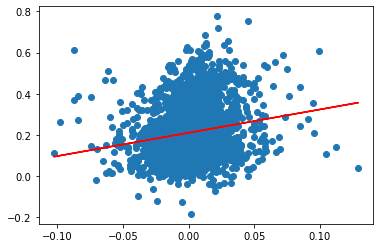

In [77]:
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

In [78]:
print(model.coef_)
print(model.intercept_)

[1.13031361]
0.21078970230186223


In [79]:
r2_score(y, y_pred)


0.03572712347756213

In [80]:
mean_squared_error(y, y_pred)

0.01554903399324957